In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/SD
!unzip /content/gdrive/MyDrive/SD/sd_train_LA_aug.zip -d .

/content/gdrive/MyDrive/SD
Archive:  /content/gdrive/MyDrive/SD/sd_train_LA_aug.zip
   creating: ./sd_train_LA_aug/
   creating: ./sd_train_LA_aug/ante_aug/
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_0.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_1.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_2.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_3.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_4.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0034-F-067Y1_patch_3_aug_5.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0054-F-079Y1_patch_3_aug_0.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0054-F-079Y1_patch_3_aug_1.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0054-F-079Y1_patch_3_aug_2.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0054-F-079Y1_patch_3_aug_3.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/0054-F-079Y1_patch_3_aug_4.jpg  
  inflating: ./sd_train_LA_aug/ante_aug/

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score,f1_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Set directories
base_dir = '/content/gdrive/MyDrive/SD/sd_train_LA_aug'
classes = ['ante_aug', 'normal_aug', 'retro_aug']
feature_dir = '/content/gdrive/MyDrive/SD/features_LA'
os.makedirs(feature_dir, exist_ok=True)


# Function to extract features and labels
def extract_features_and_labels(base_dir):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    features = []
    labels = []

    generator = datagen.flow_from_directory(base_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', shuffle=False)

    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        features_batch = features_batch.reshape((features_batch.shape[0], -1))
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * 32 >= generator.samples:
            break

    return np.vstack(features), np.concatenate(labels)

# Extract features and labels
train_features, train_labels = extract_features_and_labels(base_dir)

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)

# Split data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

#Normalize features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_labels)


# Save the trained SVM model and scaler
import joblib
joblib.dump(svm_model, os.path.join(feature_dir, 'svm_model.pkl'))
#joblib.dump(label_encoder, os.path.join(feature_dir, 'scaler.pkl'))
joblib.dump(label_encoder, os.path.join(feature_dir, 'label_encoder.pkl'))


58889256/58889256 [==============================] - 1s 0us/step
Found 632 images belonging to 3 classes.
1/1 [==============================] - 12s 12s/step


['/content/gdrive/MyDrive/SD/features_LA/label_encoder.pkl']

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set directories
test_base_dir = '/content/gdrive/MyDrive/KD/output_patches_LA'
feature_dir = '/content/gdrive/MyDrive/SD/features_LA'

# Define class labels
classes = ['ante_aug', 'normal','retro_aug']

# Load the trained SVM model and label encoder
svm_model = joblib.load(os.path.join(feature_dir, 'svm_model.pkl'))
label_encoder = joblib.load(os.path.join(feature_dir, 'label_encoder.pkl'))

# Define the true label lists
ante_aug = ['0056-F-069Y1_patch_2', '0056-F-069Y1_patch_3', '0202-F-068Y1_patch_2', '0235-F-073Y1_patch_2', '0262-F-084Y1_patch_3', '0265-F-081Y1_patch_4', '0277-F-050Y1_patch_3', '0291-M-073Y1_patch_3', '0395-M-080Y1_patch_3', '0420-F-079Y1_patch_3', '0485-M-062Y1_patch_4']  # Add your image names/parts here
retro_aug = ['0230-F-078Y1_patch_2', '0265-F-081Y1_patch_0', '0487-F-047Y1_patch_2']  # Add your image names/parts here

# Function to extract features from the test data
def extract_features(base_dir):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    features = []
    filepaths = []

    generator = datagen.flow_from_directory(
        base_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False,
        classes=['.']  # This ensures it reads images directly from base_dir
    )

    for inputs_batch in generator:
        if inputs_batch.size == 0:
            continue
        features_batch = feature_extractor.predict(inputs_batch)
        features_batch = features_batch.reshape((features_batch.shape[0], -1))
        features.append(features_batch)

        # Extract filepaths corresponding to the batch
        filepaths.extend(generator.filepaths[len(filepaths):len(filepaths) + len(inputs_batch)])

        # Break the loop when all images are processed
        if len(filepaths) >= generator.samples:
            break

    if not features:
        print("No features were extracted.")
    if not filepaths:
        print("No filepaths were found.")

    return np.vstack(features) if features else np.array([]), filepaths

# Extract features from the test data
test_features, filepaths = extract_features(test_base_dir)

# Debugging: Print the number of features and filepaths extracted
print(f"Number of features extracted: {test_features.shape[0]}")
print(f"Number of filepaths found: {len(filepaths)}")
print(filepaths)


Found 404 images belonging to 1 classes.
1/1 [==============================] - 11s 11s/step
Number of features extracted: 404
Number of filepaths found: 404
['/content/gdrive/MyDrive/KD/output_patches_LA/./0006-F-031Y1_patch_0.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0006-F-031Y1_patch_1.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0006-F-031Y1_patch_2.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0006-F-031Y1_patch_3.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0010-F-037Y1_patch_0.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0010-F-037Y1_patch_1.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0010-F-037Y1_patch_2.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0010-F-037Y1_patch_3.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0012-F-013Y1_patch_0.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0012-F-013Y1_patch_1.jpg', '/content/gdrive/MyDrive/KD/output_patches_LA/./0012-F-013Y1_patch_2.jpg', '/content/gdrive

In [ ]:
# Debugging: Print the number of features and filepaths extracted
print(f"Number of features extracted: {len(test_features)}")
print(f"Number of filepaths found: {len(filepaths)}")

# Proceed only if features were extracted
if test_features.size > 0 and filepaths:
    # Make predictions on the test data
    predictions = svm_model.predict(test_features)

    # Decode the predictions to get the original class labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    print(predicted_labels)
    # Print predictions along with file paths
    for filepath, predicted_label in zip(filepaths, predicted_labels):
        print(f"Image: {filepath}, Predicted label: {predicted_label}")
else:
    print("No features or filepaths found. Check your directory structure and ensure images are being loaded correctly.")

Number of features extracted: 404
Number of filepaths found: 404
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 0. 0.
 2. 0. 0. 2. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 2. 2. 2. 0. 0. 2. 2. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

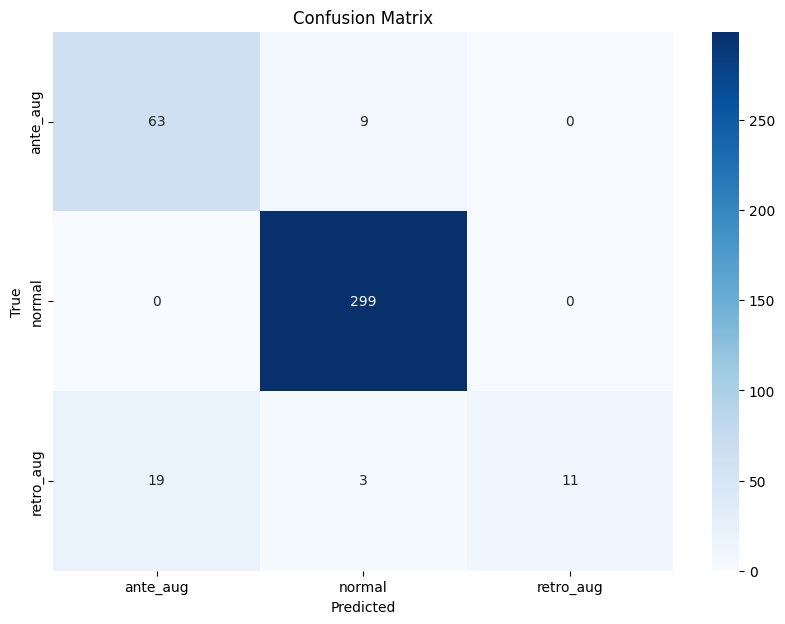

In [ ]:
# Function to get true labels from the lists

def get_true_labels(filepaths, left_aug, right_aug):
    true_labels = []
    for filepath in filepaths:
        img_name = os.path.basename(filepath)
        #print(img_name)
        base_img_name = img_name.split('_aug_')[0]
        if not base_img_name.endswith('.jpg'):
            base_img_name += '.jpg'

        if any(left in base_img_name for left in left_aug):
            true_labels.append(0)  # left_aug
        elif any(right in base_img_name for right in right_aug):
            true_labels.append(2)  # right_aug
        else:
            true_labels.append(1)  # normal

        # print('base_name:', base_img_name)
        # print('true_label:', true_labels[-1])
    return true_labels






# Proceed only if features were extracted
#if test_features.size > 0 and filepaths:
# Get true labels using the provided lists
true_labels = get_true_labels(filepaths, ante_aug, retro_aug)
print(true_labels)
# Debugging: Print the number of true labels
print(f"Number of true labels generated: {len(true_labels)}")

# Encode true labels
true_labels_encoded = np.array(true_labels)

# Make predictions on the test data
predictions = svm_model.predict(test_features)

# Debugging: Print the number of predictions
print(f"Number of predictions made: {len(predictions)}")

# Decode the predictions to get the original class labels
predicted_labels = label_encoder.inverse_transform(predictions)
print(predicted_labels)
# Calculate metrics
accuracy = accuracy_score(true_labels_encoded, predictions)
precision = precision_score(true_labels_encoded, predictions, average='weighted')
recall = recall_score(true_labels_encoded, predictions, average='weighted')
classification_rep = classification_report(true_labels_encoded, predictions, target_names=classes)
conf_matrix = confusion_matrix(true_labels_encoded, predictions)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# else:
#     print("No features or filepaths found. Check your directory structure and ensure images are being loaded correctly.")